# This file suits to the default dataframe that is given by super_pipe. The name of the columns are hardcoded and should be changed manually in case you want to evaluate your results with a super_pipe different from the one in `/export/home/cse200093/Jacques_Bio/super_pipe/py_files`

In [132]:
import pandas as pd
import re
from os.path import isfile, isdir, join, basename
from os import listdir
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean

# Import unit registry for found-gold comparison
from edsnlp.pipelines.misc.measurements.patterns import units_config
from edsnlp.pipelines.misc.measurements.measurements import (
    SimpleMeasurement,
    UnitRegistry,
)
import spacy

import sys
sys.path.insert(1, '/export/home/cse200093/Jacques_Bio/super_pipe/py_files/utils')
from extract_pandas_from_brat import extract_pandas

# Import measurements extractor
sys.path.insert(1, "/export/home/cse200093/Jacques_Bio/super_pipe/py_files/")
import extract_measurements_from_brat

UNIT_REGISTRY = UnitRegistry(units_config)

BRAT_DIR = "/export/home/cse200093/Jacques_Bio/data_bio/super_pipe_evaluate_on_full_pipe"
LABELS_TO_KEEP = ["BIO"]

RES_DIR = "/export/home/cse200093/Jacques_Bio/data_bio/super_pipe_res/evaluate_full_pipe/res.json"

In [133]:
# Load annotations

REGEX_CONVERT_SPANS = re.compile("^(\d+).*\s(\d+)$")

# Convert span to list with span_start, span_end. It considers the new lines by adding one character.
def convert_spans(span):
    span_match = REGEX_CONVERT_SPANS.match(span)
    span_start = int(span_match.group(1))
    span_end = int(span_match.group(2))
    return [span_start, span_end]

gold_df = extract_pandas(IN_BRAT_DIR=BRAT_DIR)

annotations_df = gold_df.loc[gold_df['label'] == 'AnnotatorNotes']
annotations_df = annotations_df.rename(columns={'term':'annotation', 'ann_id':'annotation_id', 'span':'ann_id'})

gold_df = gold_df.loc[gold_df['label'] != 'AnnotatorNotes']
gold_df["span_converted"] = gold_df["span"].apply(convert_spans)
display(gold_df)
display(annotations_df)

,ann_id,term,label,source,span,span_converted
0,T5,diabète insulino-requerant,DISO,CRH_-8838885096796400155.ann,261 287,"[261, 287]"
1,T6,intoxication tabagique,DISO,CRH_-8838885096796400155.ann,452 474,"[452, 474]"
2,T7,alcool occasionnel,DISO,CRH_-8838885096796400155.ann,476 494,"[476, 494]"
3,T8,Allergies,DISO,CRH_-8838885096796400155.ann,557 566,"[557, 566]"
4,T9,Diabète,DISO,CRH_-8838885096796400155.ann,597 604,"[597, 604]"
...,...,...,...,...,...,...
1421,T177,CGR,Chemical_and_drugs,CRH_-4088550345923307899.ann,1760 1763,"[1760, 1763]"
1422,T178,CGR,Chemical_and_drugs,CRH_-4088550345923307899.ann,1344 1347,"[1344, 1347]"
1425,T179,HLA classe I et II,BIO,CRH_-4088550345923307899.ann,1495 1513,"[1495, 1513]"
1456,T100,apports calciques,Chemical_and_drugs,CRH_-4088550345923307899.ann,3727 3744,"[3727, 3744]"


,annotation_id,annotation,label,source,ann_id
259,#1,A10AE05,AnnotatorNotes,CRH_-8838885096796400155.ann,T47
260,#2,A10AE05,AnnotatorNotes,CRH_-8838885096796400155.ann,T178
262,#3,C0344440,AnnotatorNotes,CRH_-8838885096796400155.ann,T1
263,#4,C0392201_5g/L,AnnotatorNotes,CRH_-8838885096796400155.ann,T265
264,#5,A10A,AnnotatorNotes,CRH_-8838885096796400155.ann,T19
...,...,...,...,...,...
1493,#68,C0373607_373µg/L,AnnotatorNotes,CRH_-4088550345923307899.ann,T237
1494,#69,C0201539_2.28µg/L,AnnotatorNotes,CRH_-4088550345923307899.ann,T238
1495,#70,C0518015_>10g/dL,AnnotatorNotes,CRH_-4088550345923307899.ann,T239
1496,#71,C0201487_P,AnnotatorNotes,CRH_-4088550345923307899.ann,T240


In [134]:
# Merge BIO and annotations, keep them only

gold_df = pd.merge(gold_df.loc[gold_df["label"].isin(LABELS_TO_KEEP)][['ann_id', 'term', 'source', 'span_converted', 'label']], annotations_df[['ann_id', 'annotation', 'source']], how = 'left', on = ["source", "ann_id"]).drop(columns="ann_id")
gold_df = gold_df.loc[~gold_df["annotation"].isna()]
# Only keep the BIO with a measurement. They must have a "_" which
# is used to separate the CUI of the measurement
gold_df = gold_df.loc[gold_df["annotation"].str.contains("_")].reset_index(drop=True)
gold_df

,term,source,span_converted,label,annotation
0,LDL cholestérol,CRH_-8838885096796400155.ann,"[6535, 6550]",BIO,C0202117_1.43g/L
1,HbA1c,CRH_-8838885096796400155.ann,"[6180, 6185]",BIO,C0202054_8.6%
2,anti IA2,CRH_-8838885096796400155.ann,"[6099, 6107]",BIO,C0201519_N
3,Anticorps anti GAD,CRH_-8838885096796400155.ann,"[6077, 6095]",BIO,C1295017_N
4,Monocytes,CRH_-8838885096796400155.ann,"[5311, 5320]",BIO,C0200637_0.21x10^9/L
...,...,...,...,...,...
190,VHC : sérologie,CRH_-4088550345923307899.ann,"[4365, 4380]",BIO,C0201487_P
191,VIH,CRH_-4088550345923307899.ann,"[4415, 4418]",BIO,C0459958_N
192,Polynucléaires ba…,CRH_-4088550345923307899.ann,"[6199, 6217]",BIO,C0200638_0.05x10^9/L
193,Chlorure,CRH_-4088550345923307899.ann,"[6418, 6426]",BIO,C0201952_103mmol/L


In [135]:
# Separate annotation into label + measurement column

gold_df[["label", "found"]] = pd.DataFrame(gold_df["annotation"].apply(lambda annotation: [[item] for item in annotation.split("_")]).tolist())
gold_df = gold_df.drop(columns=["annotation"])
gold_df

,term,source,span_converted,label,found
0,LDL cholestérol,CRH_-8838885096796400155.ann,"[6535, 6550]",[C0202117],[1.43g/L]
1,HbA1c,CRH_-8838885096796400155.ann,"[6180, 6185]",[C0202054],[8.6%]
2,anti IA2,CRH_-8838885096796400155.ann,"[6099, 6107]",[C0201519],[N]
3,Anticorps anti GAD,CRH_-8838885096796400155.ann,"[6077, 6095]",[C1295017],[N]
4,Monocytes,CRH_-8838885096796400155.ann,"[5311, 5320]",[C0200637],[0.21x10^9/L]
...,...,...,...,...,...
190,VHC : sérologie,CRH_-4088550345923307899.ann,"[4365, 4380]",[C0201487],[P]
191,VIH,CRH_-4088550345923307899.ann,"[4415, 4418]",[C0459958],[N]
192,Polynucléaires ba…,CRH_-4088550345923307899.ann,"[6199, 6217]",[C0200638],[0.05x10^9/L]
193,Chlorure,CRH_-4088550345923307899.ann,"[6418, 6426]",[C0201952],[103mmol/L]


In [136]:
# Load results from super_pipe and format It
# To keep BIOs instead of BIO_comp

res_df = pd.read_json(RES_DIR)

def retrieve_span_of_terms_linked_to_measurement(term, term_linked_to_measurement, term_span):
    return [term_span[0] + term.find(term_linked_to_measurement), term_span[0] + term.find(term_linked_to_measurement) + len(term_linked_to_measurement)]

res_df["span_converted"] = res_df.apply(lambda row: retrieve_span_of_terms_linked_to_measurement(row["term"], row["terms_linked_to_measurement"], row["span_converted"]), axis=1)

res_df = res_df[["terms_linked_to_measurement", "term", "source", "span_converted", "label", "found"]].rename(columns={"term":"full_term", "terms_linked_to_measurement":"term"})
res_df

,term,full_term,source,span_converted,label,found
0,hémoglobines glyquées,"hémoglobines glyquées : mars 2017 : 7.5 % , ce...",CRH_-6070744700027231896.ann,"[1534, 1555]",[C0202054],"[= 7.5 percent, = 8.0 percent]"
1,créatinine,créatinine : 60 µmol/l,CRH_-6070744700027231896.ann,"[2229, 2239]",[C0201975],[= 60.0 µmol_per_l]
2,Leucocytes,Leucocytes ¦x10*9/L ¦9.6 ¦4-10,CRH_-6070744700027231896.ann,"[3675, 3685]",[C0023508],[= 9600000000.0 per_l]
3,Hématies,Hématies ¦x10*12/L¦4.91 ¦4.00-5.00,CRH_-6070744700027231896.ann,"[3706, 3714]",[C0014772],[= 4910000000000.0 per_l]
4,Hémoglobine,Hémoglobine ¦g/dL ¦13.7 ¦12.0-16.0,CRH_-6070744700027231896.ann,"[3741, 3752]",[C0518015],[= 13.7 g_per_dl]
...,...,...,...,...,...,...
183,Monocytes,Monocytes ¦x10*9/L ¦0.21 ¦0.2-1,CRH_-8838885096796400155.ann,"[5311, 5320]",[C0200637],[= 210000000.0 per_l]
184,Anticorps anti GAD,Anticorps anti GAD et anti IA2 négatifs,CRH_-8838885096796400155.ann,"[6077, 6095]",[C1271672],[= 0.0 bool]
185,anti IA2,Anticorps anti GAD et anti IA2 négatifs,CRH_-8838885096796400155.ann,"[6099, 6107]","[C1294736, C1273975]",[= 0.0 bool]
186,HbA1c,HbA1c ce jour à 8.6 %,CRH_-8838885096796400155.ann,"[6180, 6185]",[C0202054],[= 8.6 percent]


In [137]:
# Link each found BIO to one annoytated BIO

def is_overlapping(a, b):
    # Return true if a segment is overlapping b
    # else False
    return min(a[1], b[1]) > max(a[0], b[0])

linked_gold = []
# The following variable is useful for counting number of non mapped rows
# of gold_df and as a consequence the number of false negatives
indexes_of_mapped_gold = set()
for _, row in res_df.iterrows():
    linked_gold_part = [[], []]
    for gold_index, (gold_span, gold_label, gold_found) in gold_df.loc[gold_df["source"] == row["source"]][["span_converted", "label", "found"]].iterrows():
        if is_overlapping(row["span_converted"], gold_span):
            indexes_of_mapped_gold.add(gold_index)
            linked_gold_part[0] += gold_label
            linked_gold_part[1] += gold_found
    linked_gold.append(linked_gold_part)

final_df = res_df.join(pd.DataFrame(linked_gold, columns=["gold_label", "gold_found"]))
final_df

,term,full_term,source,span_converted,label,found,gold_label,gold_found
0,hémoglobines glyquées,"hémoglobines glyquées : mars 2017 : 7.5 % , ce...",CRH_-6070744700027231896.ann,"[1534, 1555]",[C0202054],"[= 7.5 percent, = 8.0 percent]",[C0202054],[7.5% 8%]
1,créatinine,créatinine : 60 µmol/l,CRH_-6070744700027231896.ann,"[2229, 2239]",[C0201975],[= 60.0 µmol_per_l],[C0201975],[60 µmol/L]
2,Leucocytes,Leucocytes ¦x10*9/L ¦9.6 ¦4-10,CRH_-6070744700027231896.ann,"[3675, 3685]",[C0023508],[= 9600000000.0 per_l],[C0023508],[9.6*10^9/L]
3,Hématies,Hématies ¦x10*12/L¦4.91 ¦4.00-5.00,CRH_-6070744700027231896.ann,"[3706, 3714]",[C0014772],[= 4910000000000.0 per_l],[C0014772],[4.91x10^12/L]
4,Hémoglobine,Hémoglobine ¦g/dL ¦13.7 ¦12.0-16.0,CRH_-6070744700027231896.ann,"[3741, 3752]",[C0518015],[= 13.7 g_per_dl],[C0518015],[13.7g/dL]
...,...,...,...,...,...,...,...,...
183,Monocytes,Monocytes ¦x10*9/L ¦0.21 ¦0.2-1,CRH_-8838885096796400155.ann,"[5311, 5320]",[C0200637],[= 210000000.0 per_l],[C0200637],[0.21x10^9/L]
184,Anticorps anti GAD,Anticorps anti GAD et anti IA2 négatifs,CRH_-8838885096796400155.ann,"[6077, 6095]",[C1271672],[= 0.0 bool],[C1295017],[N]
185,anti IA2,Anticorps anti GAD et anti IA2 négatifs,CRH_-8838885096796400155.ann,"[6099, 6107]","[C1294736, C1273975]",[= 0.0 bool],[C0201519],[N]
186,HbA1c,HbA1c ce jour à 8.6 %,CRH_-8838885096796400155.ann,"[6180, 6185]",[C0202054],[= 8.6 percent],[C0202054],[8.6%]


In [138]:
# Convert to SimpleMeasurement to evaluate precision in further step
measurements_extractor = extract_measurements_from_brat.ExtractMeasurements()
nlp = measurements_extractor.nlp_from_label_key


def convert_to_SimpleMeasurement(measurement, gold, unit_registry=UNIT_REGISTRY):
    if gold:
        doc = nlp(measurement)
        return [item._.value for item in doc.spans["measurements"]]
    else:
        value_unit = measurement.split(" ")
        return SimpleMeasurement(
            value_range=value_unit[0],
            value=float(value_unit[1]),
            unit=value_unit[2],
            registry=unit_registry,
        )


# Found are stored with a unit written as STH_PER_STH... so we can directly use SimpleMeasurement class
final_df["found"] = final_df["found"].apply(
    lambda measurements: [
        convert_to_SimpleMeasurement(measurement, False) for measurement in measurements
    ]
)
# Gold are stored with human written units so we need the measurements pipe to extract the measurements
final_df["gold_found"] = final_df["gold_found"].apply(
    lambda measurements: [item for measurement in measurements for item in convert_to_SimpleMeasurement(measurement, True)]
)

display(final_df)

,term,full_term,source,span_converted,label,found,gold_label,gold_found
0,hémoglobines glyquées,"hémoglobines glyquées : mars 2017 : 7.5 % , ce...",CRH_-6070744700027231896.ann,"[1534, 1555]",[C0202054],"[7.5 percent, 8.0 percent]",[C0202054],"[7.5 percent, 8.0 percent]"
1,créatinine,créatinine : 60 µmol/l,CRH_-6070744700027231896.ann,"[2229, 2239]",[C0201975],[60.0 µmol_per_l],[C0201975],[60.0 µmol_per_l]
2,Leucocytes,Leucocytes ¦x10*9/L ¦9.6 ¦4-10,CRH_-6070744700027231896.ann,"[3675, 3685]",[C0023508],[9600000000.0 per_l],[C0023508],[9600000000.0 per_l]
3,Hématies,Hématies ¦x10*12/L¦4.91 ¦4.00-5.00,CRH_-6070744700027231896.ann,"[3706, 3714]",[C0014772],[4910000000000.0 per_l],[C0014772],[4910000000000.0 per_l]
4,Hémoglobine,Hémoglobine ¦g/dL ¦13.7 ¦12.0-16.0,CRH_-6070744700027231896.ann,"[3741, 3752]",[C0518015],[13.7 g_per_dl],[C0518015],[13.7 g_per_dl]
...,...,...,...,...,...,...,...,...
183,Monocytes,Monocytes ¦x10*9/L ¦0.21 ¦0.2-1,CRH_-8838885096796400155.ann,"[5311, 5320]",[C0200637],[210000000.0 per_l],[C0200637],[210000000.0 per_l]
184,Anticorps anti GAD,Anticorps anti GAD et anti IA2 négatifs,CRH_-8838885096796400155.ann,"[6077, 6095]",[C1271672],[0.0 bool],[C1295017],[0.0 bool]
185,anti IA2,Anticorps anti GAD et anti IA2 négatifs,CRH_-8838885096796400155.ann,"[6099, 6107]","[C1294736, C1273975]",[0.0 bool],[C0201519],[0.0 bool]
186,HbA1c,HbA1c ce jour à 8.6 %,CRH_-8838885096796400155.ann,"[6180, 6185]",[C0202054],[8.6 percent],[C0202054],[8.6 percent]


In [139]:
# In order to have detailed results

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(final_df)

,term,full_term,source,span_converted,label,found,gold_label,gold_found
0,hémoglobines glyquées,"hémoglobines glyquées : mars 2017 : 7.5 % , ce...",CRH_-6070744700027231896.ann,"[1534, 1555]",[C0202054],"[7.5 percent, 8.0 percent]",[C0202054],"[7.5 percent, 8.0 percent]"
1,créatinine,créatinine : 60 µmol/l,CRH_-6070744700027231896.ann,"[2229, 2239]",[C0201975],[60.0 µmol_per_l],[C0201975],[60.0 µmol_per_l]
2,Leucocytes,Leucocytes ¦x10*9/L ¦9.6 ¦4-10,CRH_-6070744700027231896.ann,"[3675, 3685]",[C0023508],[9600000000.0 per_l],[C0023508],[9600000000.0 per_l]
3,Hématies,Hématies ¦x10*12/L¦4.91 ¦4.00-5.00,CRH_-6070744700027231896.ann,"[3706, 3714]",[C0014772],[4910000000000.0 per_l],[C0014772],[4910000000000.0 per_l]
4,Hémoglobine,Hémoglobine ¦g/dL ¦13.7 ¦12.0-16.0,CRH_-6070744700027231896.ann,"[3741, 3752]",[C0518015],[13.7 g_per_dl],[C0518015],[13.7 g_per_dl]
5,Hématocrite,Hématocrite ¦% ¦41.1 ¦37.0-45.0,CRH_-6070744700027231896.ann,"[3776, 3787]",[C0018935],[41.1 percent],[C0018935],[41.1 percent]
6,VGM,VGM ¦fL ¦83.7 ¦82.0-98.0,CRH_-6070744700027231896.ann,"[3808, 3811]",[C0863148],[83.7 fl],[C0863148],[83.7 fl]
7,TCMH,TCMH ¦pg ¦27.9 ¦27.0-32.0,CRH_-6070744700027231896.ann,"[3833, 3837]",[C0369183],[27.9 pg],[C0369183],[27.9 pg]
8,CCMH,CCMH ¦g/dL ¦33.3 ¦32.0-35.0,CRH_-6070744700027231896.ann,"[3859, 3863]",[C0474535],[33.3 g_per_dl],[C0474535],[33.3 g_per_dl]
9,Plaquettes,Plaquettes ¦x10*9/L ¦326 ¦150-400,CRH_-6070744700027231896.ann,"[3887, 3897]",[C0032181],[326000000000.0 per_l],[C0032181],[326000000000.0 per_l]


In [140]:
# Get true positives, false positives and false negatives

# Convert to set to make intersections
# This is the method we have always used so far
# To check if we have a true positive or not:
# If and only if the intersection is not empty, that's a match

final_df["label"] = final_df["label"].apply(set)
final_df["gold_label"] = final_df["gold_label"].apply(set)

def check_good_label(label, gold_label):
    return len(label.intersection(gold_label)) > 0

def check_good_measure(found, gold_found):
    # We must do this function because
    # we cannot compare 2 measures with different units
    # else an error will be raised
    
    if len(found) != len(gold_found): return False
    # Check if all found measures are in gold
    # With same length, that means that found == gold
    for found_measure in found:
        temp = 0
        for gold_measure in gold_found:
            try:
                if found_measure == gold_measure:
                    temp = 1
                    break
            except:
                continue
        if temp == 0: return False
    return True

# Create a list of 0, 1 and 2
# We label 0 for tp, 1 for fp and 2 for fn
# tp being a match in CUI and all measures at the same time
tpfpfn = []
for _, (label, found, gold_label, gold_found) in final_df[["label", "found", "gold_label", "gold_found"]].iterrows():
    if check_good_label(label, gold_label) and check_good_measure(found, gold_found):
        tpfpfn.append(0)
    else:
        tpfpfn.append(1)
# fn are the labeled data which are not found by our super_pipe
# i.e the number of rows of gold_df which are not mapped when merging
# gold_df and res_df
# We use the variable indexes_of_mapped_gold we created before 
tpfpfn += [2 for _ in range(len(gold_df) - len(indexes_of_mapped_gold))]

In [141]:
# Bootstrap for recall, precision and f1score
def get_recall_precision_f1score(tp, fp, fn):
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1score = 2 * (recall * precision) / (recall + precision)
    return recall, precision, f1score

n_resamples = 1000000
part_size = 25
recalls = []
precisions = []
f1scores = []
for i in range(n_resamples):
    part = np.random.choice(tpfpfn, size=len(tpfpfn), replace=True).tolist()
    tp = part.count(0)
    fp = part.count(1)
    fn = part.count(2)
    recall, precision, f1score = get_recall_precision_f1score(tp, fp, fn)
    recalls.append(recall)
    precisions.append(precision)
    f1scores.append(f1score)

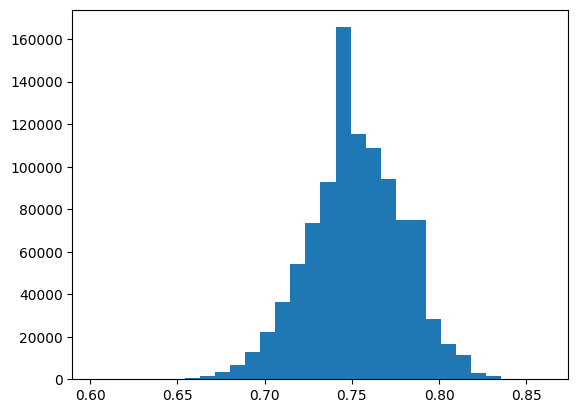

Mean:  0.7524957224585824
Confidence interval:  [0.69536424 0.80243161]


In [142]:
plt.hist(f1scores, bins = 30)
plt.show()
print("Mean: ", mean(f1scores))
conf_interval_f1score = np.percentile(f1scores,[2.5,97.5])
print("Confidence interval: ",conf_interval_f1score)

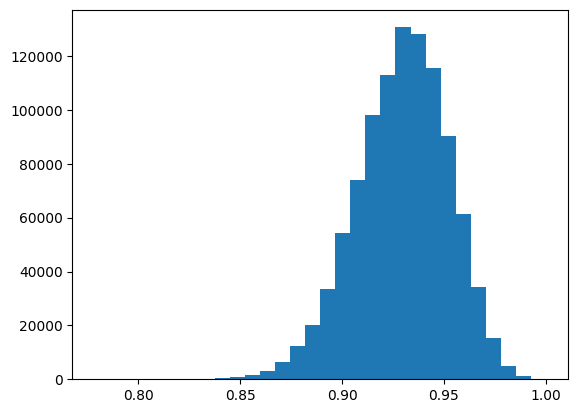

Mean:  0.9296758187107916
Confidence interval:  [0.88235294 0.96969697]


In [143]:
plt.hist(recalls, bins = 30)
plt.show()
print("Mean: ", mean(recalls))
conf_interval_recall = np.percentile(recalls,[2.5,97.5])
print("Confidence interval: ",conf_interval_recall)

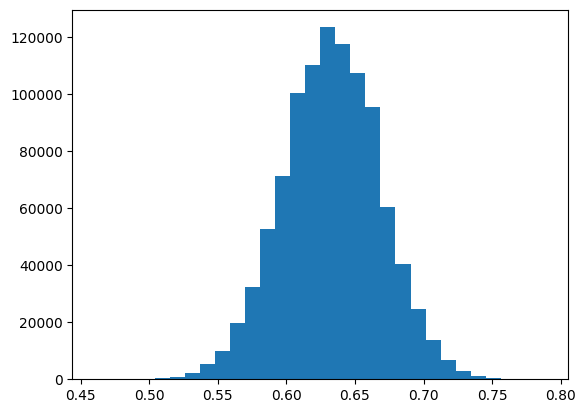

Mean:  0.6328729492691222
Confidence interval:  [0.56315789 0.70108696]


In [144]:
plt.hist(precisions, bins = 30)
plt.show()
print("Mean: ", mean(precisions))
conf_interval_precision = np.percentile(precisions,[2.5,97.5])
print("Confidence interval: ",conf_interval_precision)

In [145]:
final_df.loc[~final_df.apply(lambda row: check_good_measure(row["found"], row["gold_found"]), axis=1)]

,term,full_term,source,span_converted,label,found,gold_label,gold_found
19,Osmolarité calculée,Osmolarité calculée ¦mOsmol/L¦ 306 ¦290-308,CRH_-6070744700027231896.ann,"[4202, 4221]",{C0202150},[306.0 per_l],{C0201804},[306.0 nounit]
37,Sodium /24h,Sodium /24h ¦mmol/24h¦170 ¦40-220,CRH_-6070744700027231896.ann,"[4808, 4819]",{C1278233},[170.0 mmol],{C1256585},"[170.0 mmol, 24.0 h]"
39,Potassium /24h,Potassium /24h ¦mmol/24h¦48 ¦25-125,CRH_-6070744700027231896.ann,"[4866, 4880]",{C0278369},[48.0 mmol],{C0202195},"[48.0 mmol, 24.0 h]"
41,Créatinine /24h,Créatinine /24h ¦mmol/24h¦14.4 + ¦6.0-13.0,CRH_-6070744700027231896.ann,"[4928, 4943]",{C2732861},[14.4 mmol],{C1318439},"[14.4 mmol, 24.0 h]"
43,Urée /24h,Urée /24h ¦mmol/24h¦454 ¦430-710,CRH_-6070744700027231896.ann,"[4991, 5000]",{C1278234},[454.0 mmol],{C0428278},"[454.0 mmol, 24.0 h]"
45,Glucose /24h,Glucose /24h ¦mmol/24h¦1.5 ¦<2.8,CRH_-6070744700027231896.ann,"[5047, 5059]",{C2732796},[1.5 mmol],{C0004076},"[1.5 mmol, 24.0 h]"
47,Protéines /24h,Protéines /24h ¦g/24h ¦0.26 + ¦<0.15,CRH_-6070744700027231896.ann,"[5110, 5124]",{C0202204},[0.26 g],{C0428541},"[0.26 g, 24.0 h]"
50,Microalbumine /24h,Microalbumine /24h ¦mg/24h ¦129 + ¦3-30,CRH_-6070744700027231896.ann,"[5215, 5233]",{C0202139},[129.0 mg],{C0740086},"[129.0 mg, 24.0 h]"
59,hyperleucocytose,"hyperleucocytose,CRP négative",CRH_-6070744700027231896.ann,"[6952, 6968]",{C0162401},[0.0 bool],{},[]
75,anticentromère,anticentromère les te du bilan immuno est négatif,CRH_-3185681183879057337.ann,"[11099, 11113]",{C0201361},[0.0 bool],{C0201361},[1.0 bool]
